## What should be presented in the case study:

#### 1. Degree (strength) distribution


#### 2. Two of the following characteristics:

    2.1 Average path length

    2.2 Clustering coefficient

    2.3 Small-worldness


 #### 3. At least one of centrality measures: 

    3.1 Degree centrality￼

    3.2 Closeness centrality￼

    3.3 Betweenness

    3.4 Prestige

    3.5 Decay centrality

#### 4. You need to consider at least 2 networks

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy.stats import kstest, powerlaw
from functools import partial

# Data loading

In [3]:
path = "./data/"
fileName2019 = "EU_routes_2019.csv.gz"
fileName2022 = "EU_routes_2022.csv.gz"
fileAirports = "airports_clean.csv"
routes2019 = pd.read_csv(path + fileName2019)
routes2022 = pd.read_csv(path + fileName2022)
airports = pd.read_csv(path+fileAirports)
routes = {"2019": routes2019, "2022": routes2022}
years = ["2019", "2022"]

In [4]:
#create directed and undirected network object 
G2019_directed=nx.from_pandas_edgelist(routes2019, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2019_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G2022_directed=nx.from_pandas_edgelist(routes2022, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G_directed = {"2019": G2019_directed, "2022": G2022_directed}
G_undirected = {"2019": G2019_undirected, "2022": G2022_undirected}
# Returns the biggest giant strongly connected component in the network
G2019_directed_connected = G2019_directed.subgraph(sorted(nx.strongly_connected_components(G2019_directed), key = len, reverse = True)[0])
G2022_directed_connected = G2022_directed.subgraph(sorted(nx.strongly_connected_components(G2022_directed), key = len, reverse = True)[0])
G_directed_connected = {"2019": G2019_directed_connected, "2022": G2022_directed_connected}

# Data exploration

Using opensky-network.org's Covid-19 Dataset showing air-traffic for January 2019 and Oktober 2022

Considering Europe and excluding all flights that only appear once a month or take off and land on the same airfield to ensure data quality

We use the unique callsigns (indicating different carriers) of the flights as weights for multiple appearances

In [3]:
# Using opensky-network.org's Covid-19 Dataset showing air-traffic for January 2019 and Oktober 2022
# Considering Europe and excluding all flights that only appear once a month
# Number of unique origin_IATA_IATAs
for year in years:
    print(f"{year:4}: {routes[year].origin_IATA.nunique():3} origins and {routes[year].destination_IATA.nunique():3} destinations with {routes[year].weight.count()} total connections that appeared on more than one day in the month")

2019: 368 origins and 405 destinations with 7952 total connections
2022: 489 origins and 527 destinations with 13369 total connections


In [14]:
for year in years:
    print(f"{year:4}: Number of nodes: {G_directed[year].number_of_nodes()}")

2019: Number of nodes: 428
2022: Number of nodes: 546


In [4]:
routes2022.head()

,origin_IATA,destination_IATA,weight,rec_aircrafts,rec_days,origin_airport_name,origin_city,origin_country,origin_ICAO,origin_latitude,origin_longitude,origin_continent,destination_airport_name,destination_city,destination_country,destination_ICAO,destination_latitude,destination_longitude,destination_continent
0,AAH,BNJ,4,4,6,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Bonn-Hangelar Airport,Sankt-Augustin,Germany,EDKB,50.768890,7.163333,EU
1,AAH,CGN,2,2,5,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Cologne Bonn Airport,Cologne,Germany,EDDK,50.865900,7.142740,EU
2,AAH,ESS,2,2,2,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Essen Mulheim Airport,Essen,Germany,EDLE,51.402300,6.937330,EU
3,AAH,FMO,2,2,2,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Münster Osnabrück Airport,Munster,Germany,EDDG,52.134600,7.684830,EU
4,AAH,MGL,3,3,3,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Mönchengladbach Airport,Moenchengladbach,Germany,EDLN,51.230278,6.504444,EU


In [5]:
routes2022.shape

(13369, 19)

# Basic Network Metrics and Plots

In [8]:
#Produce adjecancy matrices for 2022 and 2022 for the directed network
adj2019 = nx.to_pandas_adjacency(G2019_directed, dtype = int)
adj2022 = nx.to_pandas_adjacency(G2022_directed, dtype = int)
adj2019.head()

,AAL,AAR,AGP,AMS,BRE,CPH,GOT,LEY,ODE,OSL,...,SPM,SQQ,ODH,KDL,LME,URE,WVN,AGE,XCR,KOQ
AAL,0,2,1,3,2,28,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
AAR,0,0,0,3,0,13,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
AGP,1,0,0,9,2,8,3,0,0,3,...,0,0,0,0,0,0,0,0,0,0
AMS,4,0,8,0,4,19,5,0,0,9,...,0,0,0,0,0,0,0,0,0,0
BRE,0,0,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


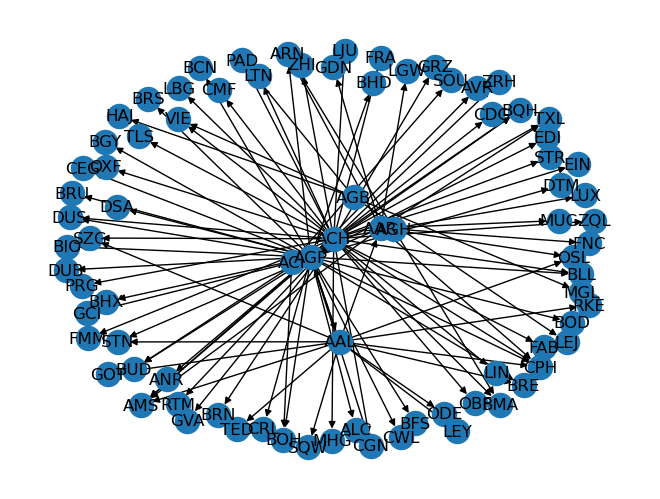

In [5]:
#draw a SAMPLE of the first 100 routes (Airports are Sorted by Origin, thus the central shape of some)
G_sample = nx.from_pandas_edgelist(routes2019[0:100], source = 'origin_IATA', target = 'destination_IATA', create_using=nx.DiGraph())
nx.draw(G_sample, with_labels = True)

In [25]:
#nx.draw(G2022_directed)

## Degree

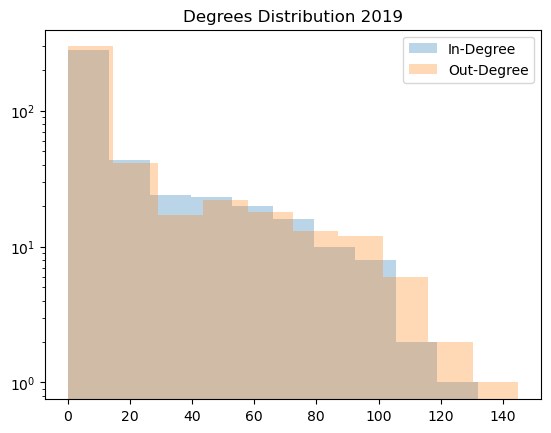

In [61]:
#caluculate in degrees 
in_degree2019 = dict(G2019_directed.in_degree)
#out degree
out_degree2019 = dict(G2019_directed.out_degree)

plt.hist(in_degree2019.values(), alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2019.values(), alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

In [8]:
G2019_directed.out_degree["SXF"]

96

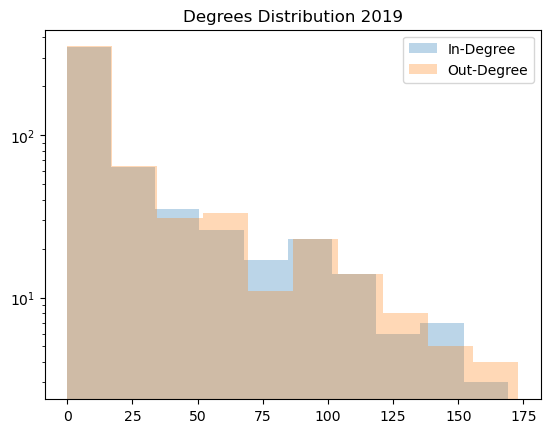

In [58]:
#caluculate in degrees 
in_degree2022 = dict(G2022_directed.in_degree)
out_degree2022 = dict(G2022_directed.out_degree)

plt.hist(in_degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

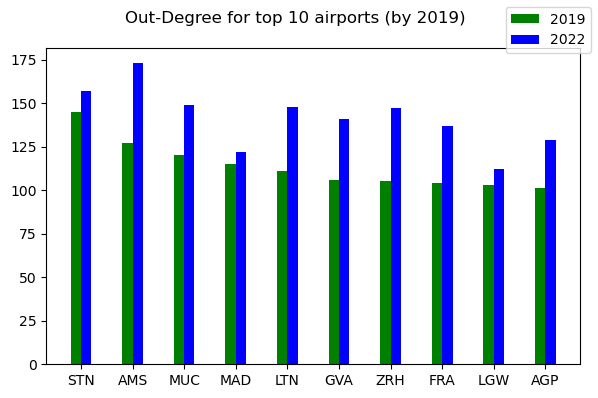

In [79]:
# out-degree barplot for top n aiports
n = 10
fig, ax = plt.subplots(1,1, figsize= (6,4))
x_axis = np.arange(n)
out_degree = pd.DataFrame.from_dict(out_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

df = out_degree
df = df.sort_values(ascending = False, by = "2019")[:n]

ax.bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
ax.bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
ax.set_xticks(x_axis, df.index)
    
fig.suptitle(f"Out-Degree for top {n} airports (by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  

In [39]:
#cannot confirm a powerlaw in degree distribution based on the p-value
in_degree2019_list = list(dict(in_degree2019).values())
fit = powerlaw.fit(in_degree2019_list)
a, loc, scale  = fit
kstest(in_degree2019_list, partial(powerlaw.cdf, a=a, loc=loc, scale=scale), alternative='two-sided')

KstestResult(statistic=0.22263641515895918, pvalue=4.074513645640479e-19)

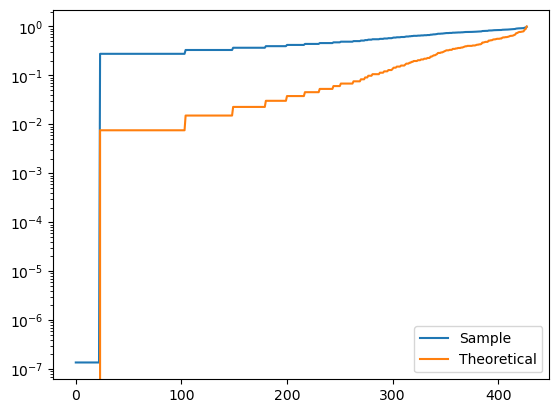

In [46]:
x_ = np.sort(powerlaw.cdf(in_degree2019_list, a=a, loc=loc, scale=scale))
x = np.sort(in_degree2019_list)/np.max(np.sort(in_degree2019_list))

plt.plot(x_, label = 'Sample')
plt.plot(x, label = 'Theoretical')
plt.yscale("log")
plt.legend()

## Strength

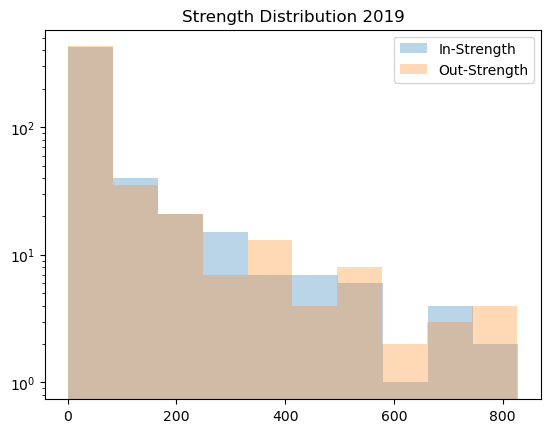

In [32]:
#strength distribution
in_strength2019 = dict(G2019_directed.in_degree(weight = 'weight'))
out_strength2019 = dict(G2019_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2019')
plt.legend()


In [33]:
max_strength = max(out_strength2019, key=out_strength2019.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max Out-Strength is at MUC with 827.


In [34]:
max_strength = max(in_strength2019, key=in_strength2019.get)
print(f"Max In-Strength is at {max_strength} with {in_strength2019[max_strength]}.")

Max In-Strength is at MUC with 829.


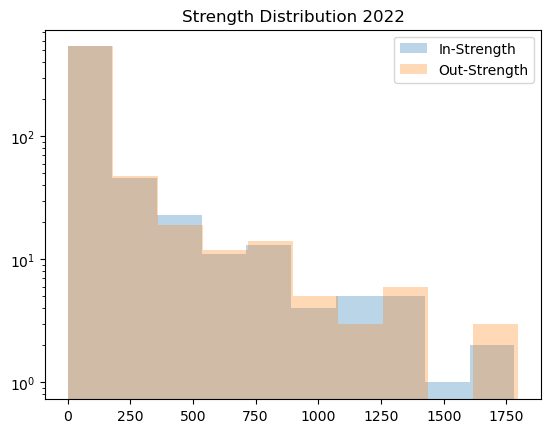

In [35]:
#strength distribution
in_strength2022 = dict(G2022_directed.in_degree(weight = 'weight'))
out_strength2022 = dict(G2022_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2022')
plt.legend()


In [36]:
max_strength = max(out_strength2022, key=out_strength2022.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2022[max_strength]}.")

Max Out-Strength is at PMI with 1798.


In [37]:
max_strength = max(in_strength2022, key=in_strength2022.get)
print(f"Max In-Strength is at {max_strength} with {in_strength2022[max_strength]}.")

Max In-Strength is at PMI with 1781.


## Distance measures

In [38]:
from networkx.algorithms.distance_measures import diameter
from networkx import average_shortest_path_length

In [40]:
G2022_directed_connected.number_of_nodes()

571

In [41]:
#Calculate the diameter: (For which network it should be done???!!)
diameter(G2019_directed_connected)

7

In [42]:
#Calculate the diameter (-||-)
average_shortest_path_length(G2019_directed_connected)

2.477467354995445

## Centrality

In [5]:
from collections import defaultdict

In [6]:
#create a nested dictionary for centrality measures and years
centrality_measures = {"degree_centrality": nx.centrality.degree_centrality, #how connected the node is
                        "betweenness_centrality": nx.centrality.betweenness_centrality, #how important the node is in terms of connecting other nodes
                        "closeness_centrality": nx.centrality.closeness_centrality} #how easily a node can reach other nodes
columns = pd.MultiIndex.from_product([years, list(centrality_measures.keys())], names = ["year", "measure"])
index = [1, 2019, 2022]
centrality_values = defaultdict(dict)
for name, func in centrality_measures.items():
    for year in years:
        centr = dict(func(G_directed_connected[year]))
        centrality_values[name][year] = centr

#reshape the nested dictionary into multi index dataframe
reformed_dict = {}
for outerKey, innerDict in centrality_values.items():
    for innerKey, values in innerDict.items():
        reformed_dict[(outerKey,
                       innerKey)] = values
        
centrality_values_df = pd.DataFrame(reformed_dict)

#join SXF and BER into one line for plotting and comparisson
ber = pd.DataFrame(centrality_values_df.loc[["SXF", "BER"],:].sum().rename("BER/SXF")).T
centrality_values_df = pd.concat([centrality_values_df, ber]).drop(["BER", "SXF"], axis = 0)

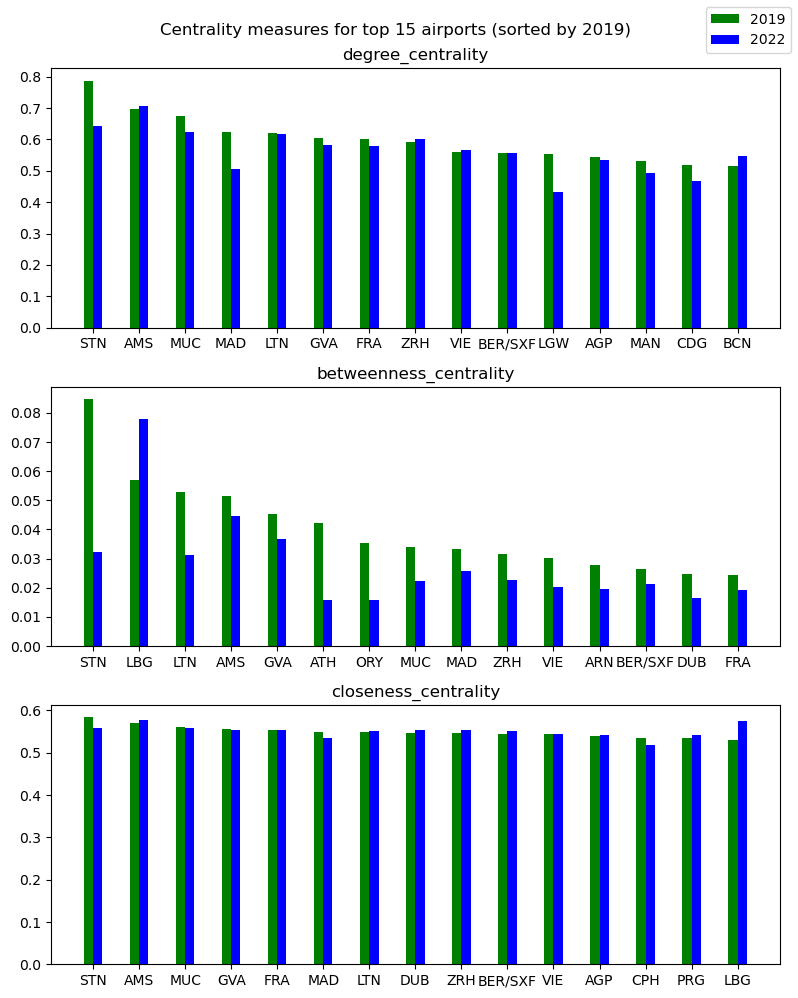

In [26]:
# centrality barplot for top n airports
n = 15
fig, ax = plt.subplots(3,1, figsize= (8,10))
x_axis = np.arange(n)
for i, measure in enumerate(centrality_measures.keys()):
    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i].set_xticks(x_axis, df.index)
    ax[i].set_title(measure)
    
fig.suptitle(f"Centrality measures for top {n} airports (sorted by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  

In [8]:
centrality_values_df.head()

degree_centrality           betweenness_centrality            \
                 2019      2022                   2019      2022   
AAL          0.072886  0.087420               0.015685  0.009210   
AAR          0.055394  0.070362               0.000059  0.002248   
AGP          0.545190  0.533049               0.019486  0.015518   
AMS          0.696793  0.705757               0.051593  0.044628   
BRE          0.174927  0.183369               0.003673  0.004411   

    closeness_centrality            
                    2019      2022  
AAL             0.413752  0.418004  
AAR             0.410287  0.416149  
AGP             0.538462  0.540946  
AMS             0.568823  0.576167  
BRE             0.446034  0.457115

# Network Density

In [16]:
for year in years:
    print(year, ": ", nx.density(G_directed[year]))

2019 :  0.04351156733568255
2022 :  0.044927244009812815


# BER Calculations

In [55]:
#Create a dictionary with the berlin Airports
berlin_airports = {}
for year in years:
    berlin_airports[year] = [x for x in routes[year].origin_IATA.loc[routes[year]["origin_city"] == "Berlin"].unique()]

berlin_airports

{'2019': ['SXF', 'TXL'], '2022': ['BER', 'TXL']}

In [56]:
# Clustering Coefficient for BER/SXF
clustering = {}
for year in years:
    clustering[year] = nx.clustering(G_directed[year], berlin_airports[year])

clustering

{'2019': {'SXF': 0.3720659185775465, 'TXL': 0.45971278228458673},
 '2022': {'BER': 0.388972033923174, 'TXL': 0}}

In [18]:
ber_centrality = centrality_values_df.loc[["BER/SXF", "TXL"],:]
ber_centrality

degree_centrality           betweenness_centrality            \
                     2019      2022                   2019      2022   
BER/SXF          0.556851  0.556503               0.026262  0.021166   
TXL              0.393586  0.006397               0.006759  0.000002   

        closeness_centrality            
                        2019      2022  
BER/SXF             0.543582  0.551765  
TXL                 0.508902  0.355842

<AxesSubplot: xlabel='None-None'>

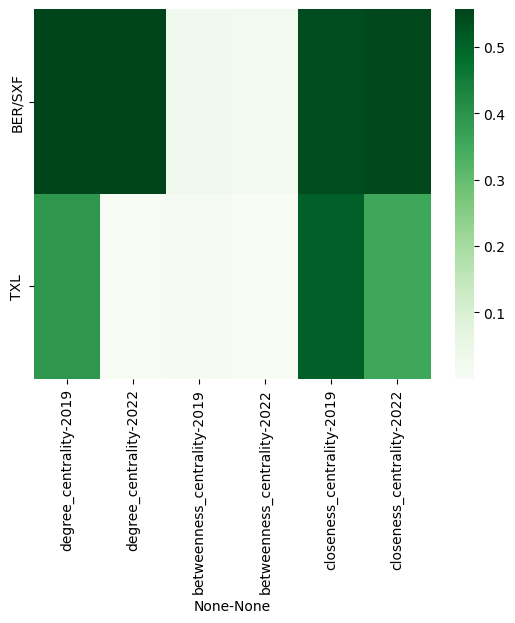

In [52]:
sns.heatmap(ber_centrality, cmap = "Greens")